In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'face-expression-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F99505%2F234911%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240616%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240616T042047Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0fe3f173d0f70399558a64247ea64e6a6a65960ebf8a63e53f280feb4dce94f7e1778b5076775821a504dffc090dd770b3c5ed63878bdf8d729e893ac356e9ae98cacc095321299fcfc64a88142f43a5564038d9d4d7461f498074d3904d4a3ad1b9addc12c309cf33120e50396043466f35d68e3b9daab4d790b297b95cdfd2717cafab867346ab74d255531d8aaf527d9d9bbdbe6c0cfa8393ca4bd9cfe4cbe7fff8ef398f5c0d2723b02c7ae64a41a3ba9f15ad51ee18078c589a3195d6eac94391233228a79a2911c38b025f1daf8392763be9f14b7660d292ec80b397d119a8f8d1ee2edea8678b75079b3f75742b1e57f5703cf7f6af3bb7e1ed40020b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 126358582 bytes downloaded
Downloaded and uncompressed: face-expression-recognition-dataset
Data source import complete.


In [2]:
import os
import cv2
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:

data_dir = "/kaggle/input/face-expression-recognition-dataset/images/train"


In [4]:

sub_folders = os.listdir(data_dir)

In [5]:

images = []
labels = []

In [6]:

for sub_folder in sub_folders:
    label = sub_folder
    path = os.path.join(data_dir, sub_folder)
    sub_folder_images = os.listdir(path)
    for image_name in sub_folder_images:
        image_path = os.path.join(path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        images.append(img)
        labels.append(label)

In [7]:
images = np.array(images)
labels = np.array(labels)
print(len(images))

28821


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

In [9]:
def preprocessing(img):
    img = img / 255.0
    img = cv2.resize(img, (48, 48))
    return img.reshape(-1, 48, 48, 1)

In [10]:

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [11]:

X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

In [12]:

data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    rotation_range=10
)


data_gen.fit(X_train)

In [13]:

label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [14]:

y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [15]:
num_classes = len(label_encoder.classes_)

y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

In [16]:
def build_model():
    model = Sequential()
    # 1st Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 2nd Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 3rd layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 4th layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # Flatten Layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Fully connected layer 2
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [17]:
model = build_model()

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

In [18]:
checkpoint = ModelCheckpoint("model.keras", monitor="val_acc", verbose=1, save_best_only=True)

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

In [20]:
reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

In [21]:
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

In [22]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    data_gen.flow(X_train, y_train_categorical, batch_size=128),
    validation_data=(X_val, y_val_categorical),
    epochs=50,
    verbose=1
)

Epoch 1/50
163/163 [==============================] - 65s 384ms/step - loss: 2.2087 - accuracy: 0.2085 - val_loss: 2.2026 - val_accuracy: 0.1683
Epoch 2/50
163/163 [==============================] - 63s 383ms/step - loss: 1.9151 - accuracy: 0.2541 - val_loss: 1.9563 - val_accuracy: 0.1483
Epoch 3/50
163/163 [==============================] - 63s 384ms/step - loss: 1.7559 - accuracy: 0.3174 - val_loss: 1.8691 - val_accuracy: 0.2758
Epoch 4/50
163/163 [==============================] - 63s 387ms/step - loss: 1.6483 - accuracy: 0.3575 - val_loss: 2.5294 - val_accuracy: 0.2277
Epoch 5/50
163/163 [==============================] - 63s 387ms/step - loss: 1.5388 - accuracy: 0.4040 - val_loss: 1.4773 - val_accuracy: 0.4263
Epoch 6/50
163/163 [==============================] - 63s 389ms/step - loss: 1.4533 - accuracy: 0.4397 - val_loss: 1.3662 - val_accuracy: 0.4657
Epoch 7/50
163/163 [==============================] - 63s 386ms/step - loss: 1.4068 - accuracy: 0.4579 - val_loss: 1.4339 - val_ac

In [24]:
model.save("modelv1.keras")

In [25]:
model.save('modelv1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


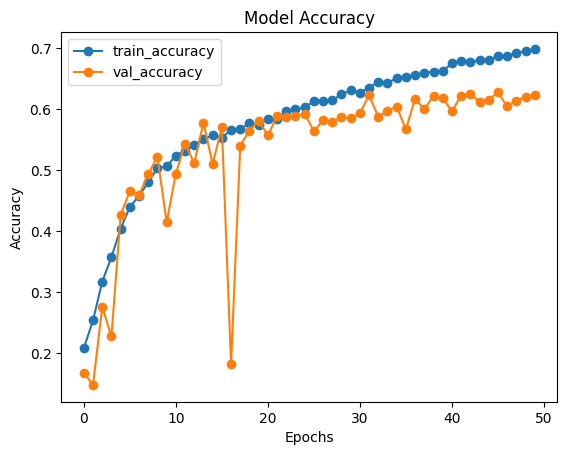

In [26]:
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()